In [1]:
cd ..

/home/dmitrii/thesis


In [2]:
from utils.kitti_api.auxiliary.laserscan import SemLaserScan

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os
from tqdm import tqdm
import torch
import json
import albumentations as A
import cv2
np.random.seed(42)

In [3]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

def mapping(labels,config):
    
    labels[labels == 252] = 10
    labels[labels == 253] = 31
    labels[labels == 254] = 30
    labels[labels == 255] = 32
    labels[labels == 256] = 16
    labels[labels == 257] = 13
    labels[labels == 258] = 18
    labels[labels == 259] = 20
    
    classes = [ -1,
                10,
                11,
                15,
                18,
                20,
                30,
                31,
                32,
                40,
                48,
                49,
                50,
                70,
                71,
                72,
                80,
                81
                ]
    for unique_value in np.unique(labels):
        if unique_value not in classes:
                labels[labels == unique_value] = -1
    
    
    for i,label in enumerate(classes):
        labels[labels == label] = i
        #print(f'Matching: {label}:{i}')
    
    return labels

Matching: -1:0
Matching: 10:1
Matching: 11:2
Matching: 15:3
Matching: 18:4
Matching: 20:5
Matching: 30:6
Matching: 31:7
Matching: 32:8
Matching: 40:9
Matching: 48:10
Matching: 49:11
Matching: 50:12
Matching: 70:13
Matching: 71:14
Matching: 72:15
Matching: 80:16
Matching: 81:17

In [4]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

def mapping(labels,config):
    
    labels[labels == 252] = 10
    labels[labels == 253] = 31
    labels[labels == 254] = 30
    labels[labels == 255] = 32
    labels[labels == 256] = 16
    labels[labels == 257] = 13
    labels[labels == 258] = 18
    labels[labels == 259] = 20
    
    for i,label in enumerate(list(config['labels'].keys())[:-8]):
        labels[labels == label] = i
    
    labels_temp = labels.copy()
    
    labels[:] = 0
    
    labels[labels_temp == 12] = 1
    labels[labels_temp == 13] = 1 #parking = road
    
    labels[labels_temp == 2] = 2
    labels[labels_temp == 4] = 2
    labels[labels_temp == 7] = 2
    labels[labels_temp == 8] = 2 #car = bus = truck = other-vehicle
    
#     labels[labels_temp == 3] = 3
#     labels[labels_temp == 5] = 3 #bycikle = motocycle
    
    labels[labels_temp == 14] = 3 #sidewalk
        
#     labels[labels_temp == 10] = 5
#     labels[labels_temp == 11] = 5 
#     labels[labels_temp == 9] = 5 #byciklist = motocyclist = person
    
    labels[labels_temp == 20] = 4 #vegetation
    
    return labels

In [5]:
CONFIG = yaml.load(open("./utils/kitti_api/config/semantic-kitti.yaml"))
    
DATA_PATH = './data/kitti_dataset/raw_data/data_odometry_velodyne/dataset/sequences/'
OUT_PATH = './data/kitti_dataset/processed_data/'
TABLE_PATH = './data/split_tables/kitti/'

os.makedirs(TABLE_PATH,exist_ok=True)

#check all records
seq_list = [DATA_PATH+i for i in os.listdir(DATA_PATH) if i.find('.')==-1]


laserscan_class = SemLaserScan(nclasses=len(list(CONFIG['labels'].keys())),project=True,sem_color_dict=CONFIG['color_map'],H=64)

/home/dmitrii/anaconda3/envs/dmitrii_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [ ]:
CONFIG['labels']

Matching: 0: 0
Matching: 1: 1
Matching: 10: 2
Matching: 11: 3
Matching: 13: 4
Matching: 15: 5
Matching: 16: 6
Matching: 18: 7
Matching: 20: 8
Matching: 30: 9
Matching: 31: 10
Matching: 32: 11
Matching: 40: 12
Matching: 44: 13
Matching: 48: 14
Matching: 49: 15
Matching: 50: 16
Matching: 51: 17
Matching: 52: 18
Matching: 60: 19
Matching: 70: 20
Matching: 71: 21
Matching: 72: 22
Matching: 80: 23
Matching: 81: 24
Matching: 99: 25

In [6]:
for seq in seq_list:
    
    scans = [i[:-4] for i in os.listdir(seq+'/velodyne/') if i.find('.bin')!=-1]
    scans = scans[0::10]
    
    for scan in tqdm(scans):
        laserscan_class.open_scan(seq+'/velodyne/'+scan + '.bin')
        laserscan_class.open_label(seq+'/labels/'+scan + '.label')
        
        #get image
        image = laserscan_class.proj_xyz
        depth = laserscan_class.proj_range
        remission = laserscan_class.proj_remission
        
        #stack image
        image = permute(image)
        depth = np.expand_dims(depth,axis=0)
        remission = np.expand_dims(remission,axis=0)
        image = np.append(image,depth,axis=0)
        image = np.append(image,remission,axis=0)
        
        #get labels
        labels = laserscan_class.proj_sem_label
        labels = mapping(labels,config=CONFIG)
        labels = np.expand_dims(labels,axis=0)
        
        #get mask
        mask = laserscan_class.proj_mask
        mask = np.expand_dims(mask,axis=0)
        
        os.makedirs(OUT_PATH+seq.split('/')[-1],exist_ok=True)
        
        #save data
        np.save(OUT_PATH+seq.split('/')[-1]+f'/{scan}_scan.npy',image)
        np.save(OUT_PATH+seq.split('/')[-1]+f'/{scan}_label.npy',labels)
        np.save(OUT_PATH+seq.split('/')[-1]+f'/{scan}_mask.npy',mask)
    

  0%|          | 0/408 [00:00<?, ?it/s]


# Prepare split tables

In [ ]:
test_seq = [
    './data/kitti_dataset/processed_data/08',
     './data/kitti_dataset/processed_data/02',
]

train_UB = [
     './data/kitti_dataset/processed_data/06',
 './data/kitti_dataset/processed_data/03',
    
         './data/kitti_dataset/processed_data/00',
     './data/kitti_dataset/processed_data/05',
    './data/kitti_dataset/processed_data/09',
     './data/kitti_dataset/processed_data/10',
]

val_UB = [
 './data/kitti_dataset/processed_data/07',
 './data/kitti_dataset/processed_data/01',
 './data/kitti_dataset/processed_data/04'
]

In [ ]:
def upload_data(seq_list: list):
    seq_arr = []
    scans = []
    for seq in seq_list:
        scans += [seq+'/'+i for i in os.listdir(seq) if i.find('scan')!=-1]
        seq_arr += [seq]*len([seq+'/'+i for i in os.listdir(seq) if i.find('scan')!=-1])

    scans = np.array(scans)
    seq_arr = np.array(seq_arr)
    return scans,seq_arr

In [ ]:
#create test

records_test,_ = upload_data(test_seq)


#create test
split = {
        'test': records_test.tolist(),
    }

with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
        json.dump(split, outfile)
        
print(f'Seq in test set: {len(test_seq)}')
print(f'Images in test set: {records_test.shape[0]}')

In [ ]:
#create UB

train_records,_ = upload_data(train_UB)
val_records,_ = upload_data(val_UB)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)

print(f'Seq in UB train set: {len(train_UB)}')
print(f'Images in UB train set: {train_records.shape[0]}')
print(f'Seq in UB val set: {len(val_UB)}')
print(f'Images in UB val set: {val_records.shape[0]}')

pretrain = val_records.tolist() + train_records.tolist()

In [ ]:
#create train and validation

part_data = [2,4,8] # % of each record, but validate only on 1% of each 

for part in part_data:
    
    train = []
    val = []
    for seq in train_UB:
        train_records,_ = upload_data([seq])
        np.random.permutation(train_records)
        train_records = train_records[:int(np.round(train_records.shape[0]*(part/100)))]
        print(f'Dataset train: {seq}, N samples: {train_records.shape[0]}')
        train += train_records.tolist()
    
    for seq in val_UB:
        val_records,_ = upload_data([seq])
        np.random.permutation(val_records)
        val_records = val_records[:int(np.round(val_records.shape[0]*(part/100)))]
        print(f'Dataset val: {seq}, N samples: {val_records.shape[0]}')
        val += val_records.tolist()
    
    print('\n')
    
    pretrain_cut = pretrain.copy()
    for i in train:
        pretrain_cut.remove(i)
    for i in val:
        pretrain_cut.remove(i) 
    
    split = {
            'train': train,
            'val': val,
            'pretrain': pretrain_cut
        }
    with open(f'{TABLE_PATH}{part}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    
    print(f'Part data: {part}%')
    print(f'Seq in UB train set: {len(train_UB)}')
    print(f'Images in UB train set: {len(train)}')
    print(f'Seq in UB val set: {len(val_UB)}')
    print(f'Images in UB val set: {len(val)}')


# Review augs

In [ ]:
prob = 100
augs = A.Compose(
                [
                    A.HorizontalFlip(p=prob),
                    A.Rotate(limit=5, p=prob),

                ]
            )
temp = np.transpose(image.astype(np.float32), (1, 2, 0))
augmented = augs(image=temp)
temp = np.transpose(temp.astype(np.float32), (2, 0, 1))
image_aug = augmented['image']
image_aug = np.transpose(image_aug.astype(np.float32), (2, 0, 1))

plt.figure(figsize=(30,10))
plt.imshow(temp[0],'gray')

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(image_aug[0],'gray')

In [ ]:
temp = labels.copy()
temp[temp != 12] = 1
temp[temp == 12] = 0

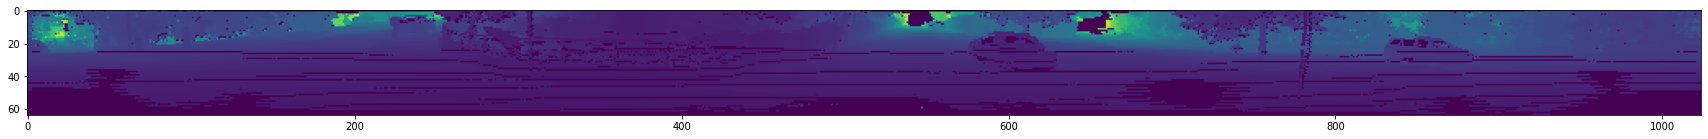

In [8]:
plt.figure(figsize=(30,10))
plt.imshow(image[0])

plt.figure(figsize=(30,10))
plt.imshow(image[1])

plt.figure(figsize=(30,10))
plt.imshow(image[2])

plt.figure(figsize=(30,10))
plt.imshow(image[3])

plt.figure(figsize=(30,10))
plt.imshow(image[4])

plt.figure(figsize=(30,10))
plt.imshow(labels[0])

